<a href="https://colab.research.google.com/github/kunwarAbhay/NLP/blob/main/RNN/RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import os
import numpy as np
import pandas as pd
from tqdm import tqdm

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import metrics

In [ ]:
import torch
import torch.nn as nn

In [ ]:
class RNN(nn.Module):
  def __init__(self, input_size, hidden_size, output_size):
    super().__init__()
    self.hidden_size = hidden_size

    self.i2h = nn.Linear(input_size, hidden_size)
    self.h2h = nn.Linear(hidden_size, hidden_size)
    self.h2o = nn.Linear(hidden_size, output_size)
    self.out = nn.LogSoftmax(dim=1)

  def forward(self, inputs, hidden):
    hidden = torch.tanh(self.i2h(inputs) + self.h2h(hidden))
    output = self.h2o(hidden)
    output = self.out(output)

    return output, hidden

  def init_hidden(self, batch_size):
    return torch.zeros(batch_size, self.hidden_size)

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

print(f"Available device: ", device)

Available device:  cuda


In [ ]:
names, nationalities = [], []

with os.scandir('data/names') as it:
  for file_name in it:
    nationality = file_name.name.split('.')[0].lower()

    with open(file_name) as file:
      for line in file:
        names.append(line.strip().lower())
        nationalities.append(nationality)

print(f"Number of data samples: {len(names)}")

Number of data samples: 20074


In [ ]:
df = pd.DataFrame(columns=['name', 'nationality'])
df['name'] = names
df['nationality'] = nationalities

df['nationality'], nationality_mapping = df.nationality.factorize()

In [ ]:
nationality_mapping

Index(['english', 'chinese', 'dutch', 'italian', 'irish', 'arabic', 'czech',
       'spanish', 'portuguese', 'russian', 'vietnamese', 'japanese', 'greek',
       'german', 'scottish', 'french', 'korean', 'polish'],
      dtype='object')

In [ ]:
print(f"Number of different nationality: {len(nationality_mapping)}")

Number of different nationality: 18


In [ ]:
df = df.sample(frac=0.1).reset_index(drop=True)

df_train, df_test = train_test_split(df, test_size=0.2)

df_train.head()

,name,nationality
1419,awryasoff,9
517,ganivet,0
1415,levitansky,9
986,rakhlevsky,9
664,yakubenko,9


In [ ]:
print(f"Shape of training data: {df_train.shape}")
print(f"Shape of test data: {df_test.shape}")

Shape of training data: (1605, 2)
Shape of test data: (402, 2)


<Axes: >

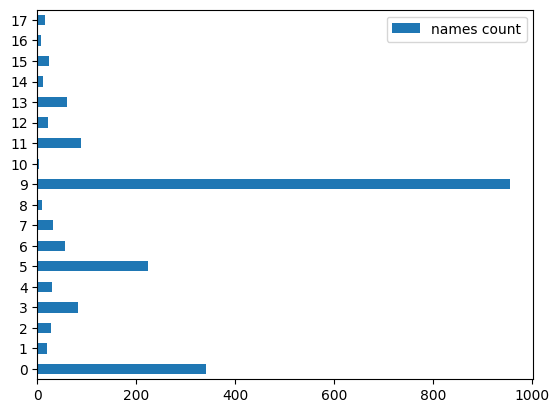

In [ ]:
names_count = df.groupby('nationality')['name'].count().tolist()

pd.DataFrame({'names count' : names_count}).plot.barh()

In [ ]:
vocab = list(set(''.join(names)))
vocab_size = len(vocab)

print(f"Vocabulary size: {len(vocab)}")
print(f"Vocabulary: {vocab_size}")

Vocabulary size: 58
Vocabulary: 58


In [ ]:
def name_to_tensor(name):
  tensor = torch.zeros(size=(len(name), vocab_size))
  for r, ch in enumerate(name):
    tensor[r][vocab.index(ch)] = 1

  return tensor

In [ ]:
name_to_tensor("jones")

tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0.

In [ ]:
hidden_size = 256
output_size = len(nationality_mapping)

model = RNN(vocab_size, hidden_size, output_size).to(device)

In [ ]:
model

RNN(
  (i2h): Linear(in_features=58, out_features=256, bias=True)
  (h2h): Linear(in_features=256, out_features=256, bias=True)
  (h2o): Linear(in_features=256, out_features=18, bias=True)
  (out): LogSoftmax(dim=1)
)

In [ ]:
def predict(model, name_tensor):
  with torch.inference_mode():
    hidden = model.init_hidden(1).to(device)

    for i in range(len(name_tensor)):
      output, hidden = model(name_tensor[i], hidden)

    _, prediction = torch.max(output, dim=1)

  return prediction.cpu().detach().numpy()[0]

In [ ]:
def evaluate(model, df):
  model.eval()

  y_pred = []
  y_true = df['nationality'].tolist()
  num_samples = df.shape[0]

  for _, row in df.iterrows():
      # Prepare the data sample
      name, nationality = row['name'], row['nationality']

      # Vectorize name and move tensor to device
      name_tensor = name_to_tensor(name).to(device)

      # Use model to prediction class
      prediction = predict(model, name_tensor)

      # Add prediction to list
      y_pred.append(prediction)

  # Return f1 score
  return metrics.f1_score(y_true, y_pred, average='micro')

In [ ]:
evaluate(model, df_test)

0.004975124378109453

In [ ]:
def train(model, df_train, df_test, optimizer, criterion, num_epochs):
  losses, f1_train, f1_test = [], [], []

  for epoch in tqdm(range(num_epochs)):
    df_train = df_train.sample(frac=1).reset_index(drop=True)

    epoch_loss = 0

    for _, row in df_train.iterrows():

      name, nationality = row['name'], row['nationality']

      name = name_to_tensor(name).to(device)
      nationality = torch.tensor([nationality]).long().to(device)

      hidden = model.init_hidden(1).to(device)

      # Iterate over all characters in the name and given the current character and the last hidden state to the model
      for i in range(len(name)):
          output, hidden = model(name[i], hidden)

      # Calculate loss
      loss = criterion(output, nationality)

      optimizer.zero_grad()

      loss.backward()

      optimizer.step()

      # Keep track of overall epoch loss
      epoch_loss += loss.item()

    losses.append(epoch_loss)

    # Compute f1 score for both TRAINING and TEST data
    f1_tr = evaluate(model, df_train)
    f1_te = evaluate(model, df_test)
    f1_train.append(f1_tr)
    f1_test.append(f1_te)

    print(f"epoch: {epoch + 1} | Loss: {epoch_loss:.3f} | f1 train: {f1_tr:.3f} | f1 test: {f1_tr:.3f}")

  return losses, f1_train, f1_test

In [ ]:
# Create the model and movie to device
model = RNN(vocab_size, hidden_size, output_size).to(device)

# Define loss function
criterion = nn.NLLLoss()

# Define optimizer (you can try, but the basic (Stochastic) Gradient Descent is actually not great)
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
num_epochs = 10

losses, f1_train, f1_test = train(model, df_train, df_test, optimizer, criterion, num_epochs)

 10%|█         | 1/10 [00:09<01:27,  9.69s/it]

epoch: 1 | Loss: 2130.508 | f1 train: 0.635 | f1 test: 0.635


 20%|██        | 2/10 [00:19<01:19,  9.91s/it]

epoch: 2 | Loss: 1954.130 | f1 train: 0.670 | f1 test: 0.670


 30%|███       | 3/10 [00:28<01:06,  9.51s/it]

epoch: 3 | Loss: 1833.169 | f1 train: 0.691 | f1 test: 0.691


 40%|████      | 4/10 [00:37<00:55,  9.28s/it]

epoch: 4 | Loss: 1758.957 | f1 train: 0.703 | f1 test: 0.703


 50%|█████     | 5/10 [00:46<00:46,  9.22s/it]

epoch: 5 | Loss: 1681.654 | f1 train: 0.702 | f1 test: 0.702


 60%|██████    | 6/10 [00:56<00:36,  9.21s/it]

epoch: 6 | Loss: 1629.373 | f1 train: 0.720 | f1 test: 0.720


 70%|███████   | 7/10 [01:04<00:26,  8.98s/it]

epoch: 7 | Loss: 1576.810 | f1 train: 0.734 | f1 test: 0.734


 80%|████████  | 8/10 [01:13<00:18,  9.04s/it]

epoch: 8 | Loss: 1514.861 | f1 train: 0.718 | f1 test: 0.718


 90%|█████████ | 9/10 [01:22<00:09,  9.08s/it]

epoch: 9 | Loss: 1463.124 | f1 train: 0.741 | f1 test: 0.741


100%|██████████| 10/10 [01:32<00:00,  9.24s/it]

epoch: 10 | Loss: 1433.815 | f1 train: 0.753 | f1 test: 0.753


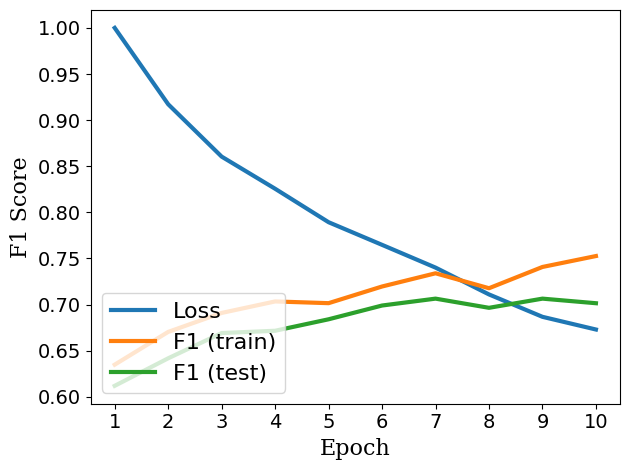

In [ ]:
x = list(range(1, len(losses)+1))

# Convert losses to numpy array
losses = np.asarray(losses)

# Normalize losses so they match the scale in the plot (we are only interested in the trend of the losses!)
losses = losses / np.max(losses)

plt.figure()

plt.plot(x, losses, lw=3)
plt.plot(x, f1_train, lw=3)
plt.plot(x, f1_test, lw=3)

font_axes = {'family':'serif','color':'black','size':16}

plt.gca().set_xticks(x)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.xlabel("Epoch", fontdict=font_axes)
plt.ylabel("F1 Score", fontdict=font_axes)
plt.legend(['Loss', 'F1 (train)', 'F1 (test)'], loc='lower left', fontsize=16)
plt.tight_layout()
plt.show()

In [ ]:
name = 'abhay'

# Convert name to a tensor and move it to the GPU (if available)
name_tensor = name_to_tensor(name).to(device)

# Use model to prediction class
prediction = predict(model, name_tensor)

# Convert class label to nationality
print(nationality_mapping[prediction])

arabic


# Reference


*   [Understanding LSTM Networks](https://colah.github.io/posts/2015-08-Understanding-LSTMs/)
*   [nus-cs4248x/3-neural-nlp
/Vanilla RNN Implementation.ipynb
](https://github.com/chrisvdweth/nus-cs4248x/blob/master/3-neural-nlp/Section%201.2%20-%20Vanilla%20RNN%20Implementation.ipynb)



